In [1]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [53]:
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.cluster import MiniBatchKMeans
import mdtraj as md
import seaborn as sns

## Make HMM from MSM

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
indir = './data/alanine_dipeptide'
topfile =  indir+'/ala2.pdb'
from glob import glob
traj_list = glob(indir+'/trajectory-*.dcd')


In [5]:
trajs = [md.load(traj_path, top=topfile) for traj_path in traj_list]

In [6]:
ftrajs = DihedralFeaturizer(sincos=False).fit_transform(trajs)

In [7]:
ftrajs[0].shape

(9999, 2)

In [57]:
cluster = MiniBatchKMeans(n_clusters=400)
ctrajs = cluster.fit_transform(ftrajs)

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


In [10]:
msm_lag = 5
M = msm.estimate_markov_model(ctrajs, msm_lag)
len(M.active_set)

400

In [20]:
n_sets=3
HMM = M.coarse_grain(ncoarse=n_sets)

BIC/AIC not available for these constraints


In [19]:
membership = HMM.metastable_memberships
membership.shape

(400, 3)

## Calculate hidden state probabilities

In [33]:
mem_trajs =  [[membership[:,i][dtraj][:, np.newaxis] for dtraj in HMM.discrete_trajectories_obs] for i in range(n_sets)]

In [34]:
all_trajs = []
for i in range(10):
    print('traj ', i)
    all_trajs.append(np.concatenate([mem_trajs[j][i] for j in range(n_sets)], axis=1))


traj  0
traj  1
traj  2
traj  3
traj  4
traj  5
traj  6
traj  7
traj  8
traj  9


In [48]:
stat_dist = HMM.stationary_distribution_obs
W = []
for dtraj in HMM.discrete_trajectories_obs:
    w = stat_dist[dtraj]
    W.append(w)

In [49]:
free_energy = -np.log(stat_dist)

In [50]:
free_energy_by_state = [free_energy*membership[:,i] for i in range(n_sets)]

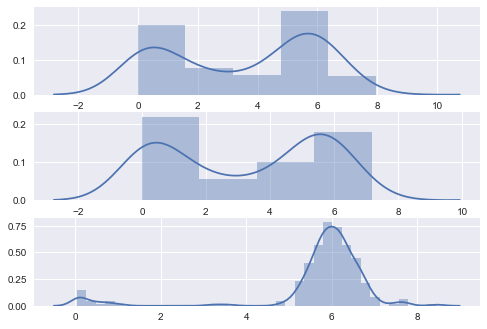

In [62]:
fig, axes = plt.subplots(n_sets)
tol = 1e-7
for i, ax in enumerate(axes):
    sns.distplot(free_energy_by_state[i][np.where(free_energy_by_state[i]>tol)[0]], ax=ax)

In [66]:
from scipy.stats import skew, kurtosis

In [69]:
properties = {}
properties['mean'] = [np.mean(x) for x in free_energy_by_state]
properties['max'] = [np.max(x) for x in free_energy_by_state]
properties['std'] = [np.std(x) for x in free_energy_by_state]
properties['skew'] = [skew(x) for x in free_energy_by_state]
properties['kurtosis'] = [kurtosis(x) for x in free_energy_by_state]

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [78]:
scaled_properties = {}
for k, v in properties.items():
    scaled_properties[k] = [x[0] for x in scaler.fit_transform(np.array(v).reshape(-1,1))]

In [80]:
np.save('Data/static_properties_01_scale.npy', scaled_properties)

In [86]:
scaled_properties = {}
for k, v in properties.items():
    v = np.abs(v)
    scaled_properties[k] = lsit(np.array(v)/np.max(v))

NameError: name 'lsit' is not defined

In [84]:
scaled_properties

{'kurtosis': <map at 0x122ccfe80>,
 'max': <map at 0x122ccffd0>,
 'mean': <map at 0x122ccfe10>,
 'skew': <map at 0x122ccf358>,
 'std': <map at 0x122ccf748>}